We will perform sentiment analysis with IMDb. The workflow is as follows:
1. EDA & cleaning
2. Baseline linear model
3. LSTM model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import collections
import itertools
import os

In [2]:
reviews_train = []
for line in open(os.getcwd() + '/data/imbd_train.txt', 'r', encoding='latin1'):
    
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open(os.getcwd() + '/data/imbd_test.txt', 'r', encoding='latin1'):
    
    reviews_test.append(line.strip())

In [3]:
target = ["positive" if i < 12500 else "negative" for i in range(25000)]

In [4]:
df1 = pd.DataFrame({"review": reviews_train, "sentiment":target})
df2 = pd.DataFrame({"review": reviews_test, "sentiment":target})


In [5]:
df = pd.concat([df1, df2]).sample(frac=1.0, random_state=42).reset_index(drop=True)

In [6]:
df

,review,sentiment
0,"When I first saw the ad for this, I was like '...",positive
1,"""A Girl's Folly"" is a sort of half-comedy, hal...",positive
2,I started watching the show from the first sea...,positive
3,This is a more interesting than usual porn mov...,positive
4,I suppose for 1961 this film was supposed to b...,negative
...,...,...
49995,I saw this movie at midnight on On Demand the ...,positive
49996,"Some aspects of this production are good, such...",negative
49997,I was not old enough to really appreciate the ...,negative
49998,Nice movie with a great soundtrack which spans...,positive


# 1. EDA & cleaning

<Axes: xlabel='count', ylabel='sentiment'>

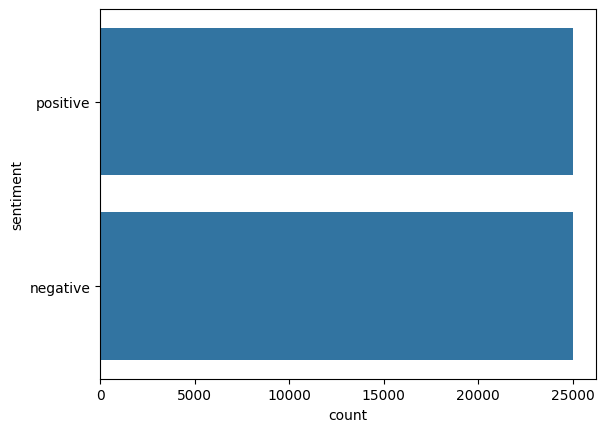

In [7]:
sns.countplot(df["sentiment"])

In [8]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

There is no null data.

### Text cleaning

In [28]:

def preprocessing_text(texts):
    # Dictionary of common English contractions and their expansions
    contractions = {
        "ain't": "are not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "daren't": "dare not",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "e'er": "ever",
        "gimme": "give me",
        "gonna": "going to",
        "gotta": "got to",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "here's": "here is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "is't": "is it",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "ne'er": "never",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "o'er": "over",
        "ol'": "old",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so is",
        "somethin'": "something",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "these're": "these are",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "this's": "this is",
        "those're": "those are",
        "tis": "it is",
        "to've": "to have",
        "twas": "it was",
        "wanna": "want to",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'd": "what did",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when'd": "when did",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "which's": "which is",
        "who'd": "who would",
        "who'd've": "who would have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why'd": "why did",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    texts = re.sub(r'<.*?>', '', texts)
    contractions_pattern = re.compile(r'\b(?:' + '|'.join(re.escape(key) for key in contractions.keys()) + r')\b', flags=re.IGNORECASE)
    def replace_contraction(match):
        return contractions.get(match.group(0).lower(), match.group(0))
    texts = contractions_pattern.sub(replace_contraction, texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    texts = re.sub(r'\s+', ' ', texts).strip()
    return ' '.join(x.lower() for x in texts.split())


In [29]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

df['review_cleaned'][0]

'when i first saw the ad for this i was like oh here we go he is done high school musical but he cannot coast along on that so now he is making appearances on other disney shows personally i love the suite life and i am a big fan of ashely tisdale but for some reason i am not too keen on zac efron although all my friends think he is the best thing since jesse mccartney but he really annoys me anyway i watched the show taking a break from english coursework and was pleasantly surprised the performances were good all round especially from the regular characters on the suite life and zac efron was not as bad as i had anticipated all in all a pretty good show'

# 2. Baseline linear model

Before we build time-consuming neural network model, simple classifier is tried.
Tfidf method is used for text vectorization.

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6254
           1       0.89      0.91      0.90      6246

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



<Axes: >

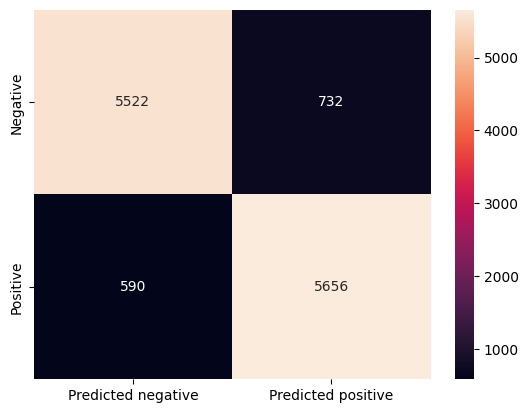

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'].map({'negative':0, 'positive':1}))
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr_clf', LogisticRegression())])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

Logistic regression provides 90% accuracy for test set, which is fast and adapted for such large datasets.

# 3. LSTM model

To quickly explore LSTM model, we firstly take only 500 characters. That is much faster way than taking full sentences.

In [31]:
df['review_cleaned_500'] = df['review_cleaned'].apply(lambda x:x[:500])

df['review_cleaned_500'][2]

'i started watching the show from the first season and at the beginning i was pretty skeptical about it original movie was kind of childish and i was just looking for some sci fi show while waiting for the bsg new season but after few episodes i became a fan i have loved the characters the not so stupid as you think he is jack o neill the not only smart samantha carter the glorious teal c women and kids favorite and brilliant dr daniel jackson of course stories sometimes not serious sometimes eve'

### Tokenize & Padding

Let's convert tokens to ID. We will use keras Tokenizer which can filter punctuations and take only most-counted 10000 words.

In [32]:
tokenizer = Tokenizer(num_words=10000)

In [33]:
tokenizer.fit_on_texts(df['review_cleaned_500'])
seq = tokenizer.texts_to_sequences(df['review_cleaned_500'])
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (50000, 116), X_min: 0, X_max: 9999


Sentiment is converted to 0 (negative) or 1 (positive).

In [34]:
y = df['sentiment'].map({'negative' : 0, 'positive' : 1}).values

Let's build the simple LSTM model using first 500 characters datasets.

In [35]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(32000, 116) (8000, 116) (10000, 116) (32000,) (8000,) (10000,)


In [36]:
y_train

array([0, 1, 1, ..., 1, 0, 0])

In [60]:
embed_size = 64
model = keras.models.Sequential([
    keras.layers.Input(shape=(None, )),
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size,  mask_zero=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, None, 64)       │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 685,473 (2.61 MB)

 Trainable params: 685,473 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
optimizer =keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 41ms/step - accuracy: 0.7194 - loss: 0.5333 - val_accuracy: 0.8288 - val_loss: 0.3837
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 122s 122ms/step - accuracy: 0.8674 - loss: 0.3243 - val_accuracy: 0.8129 - val_loss: 0.4068
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 213s 193ms/step - accuracy: 0.9046 - loss: 0.2445 - val_accuracy: 0.8288 - val_loss: 0.4016
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.9377 - loss: 0.1729 - val_accuracy: 0.8194 - val_loss: 0.5292
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - accuracy: 0.9556 - loss: 0.1272 - val_accuracy: 0.8194 - val_loss: 0.5126


<Axes: >

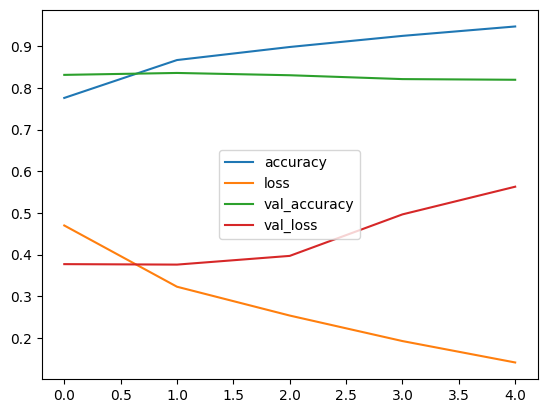

In [41]:
pd.DataFrame(history.history).plot()

This simple model is overfitted with training data as the validation loss increases.

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4976
           1       0.00      0.00      0.00      5024

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



c:\Users\Usuario\miniconda3\envs\data_analysis_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\miniconda3\envs\data_analysis_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\miniconda3\envs\data_analysis_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

<Axes: >

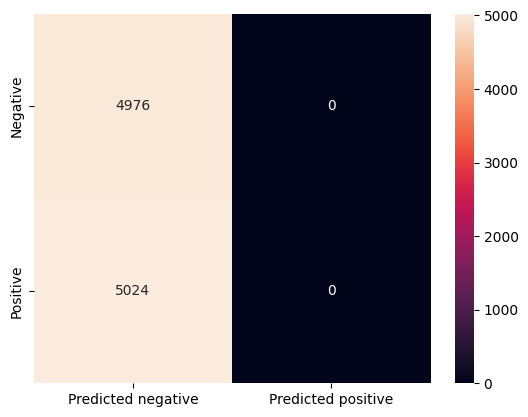

In [62]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

## Modified LSTM model

We added Dropout layers to prevent overfitting.

In [63]:
embed_size = 64
model_v2 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model_v2.summary()

c:\Users\Usuario\miniconda3\envs\data_analysis_env\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model_v2.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.5670 - loss: 0.6786 - val_accuracy: 0.7695 - val_loss: 0.5331
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.7739 - loss: 0.5478 - val_accuracy: 0.7959 - val_loss: 0.4639
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.8196 - loss: 0.4686 - val_accuracy: 0.8159 - val_loss: 0.4290
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.8362 - loss: 0.4291 - val_accuracy: 0.8250 - val_loss: 0.3992
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.8537 - loss: 0.3875 - val_accuracy: 0.8191 - val_loss: 0.3959
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.8607 - loss: 0.3721 - val_accuracy: 0.8321 - val_loss: 0.3858
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.8705 - loss: 0.3448 - val_accuracy: 0.8319 - val_loss: 0.3813
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.8802 - loss: 0.3261 - 

<Axes: >

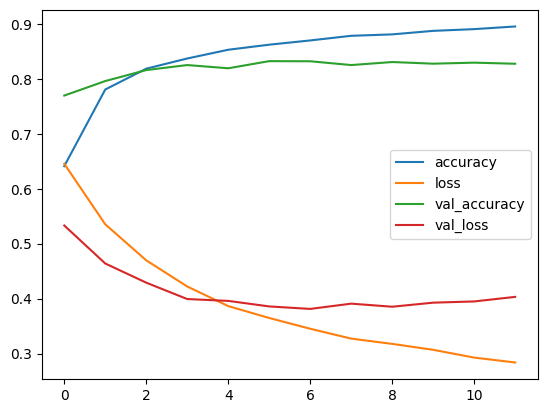

In [65]:
pd.DataFrame(history.history).plot()

Looks better than first model.

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      4976
           1       0.82      0.80      0.81      5024

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



<Axes: >

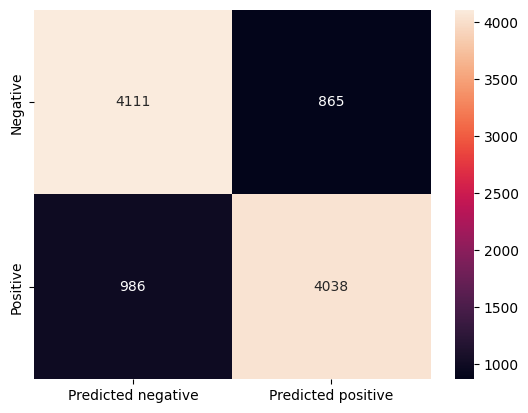

In [70]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

Use of full-sentences would increase accurcy. But it is time-consuming and seems difficult to overwhelm simple Logistic regression model.